# From shallow learning to 2020 SOTA(GPT-2, ROBERTA)


# Abstract

In this notebook I explore a variety of Machine learning models ranging from good old shallow learning(Naive naives, TF-IDF, SVMs) to the state of the art in NLP(GPT2, ROBERTA) with the goal of finding the best possible model and preprocessing steps for the task of tweet classification posted on this Kaggle competition: https://www.kaggle.com/c/nlp-getting-started  
As a by-product of this experimentation we also obtain a clear comparison across a number of popular NLP algorithms.

# Index

- [Exploratory analysis](#epa)
- [Shallow Learning](#shallow_learning)
- [Fast text](#fast_text)
- [Text preprocessing](#text_preprop)
- [BERT & ROBERTA](#bert_e2e)
- [LSTMs](#Conclusions)
- [GPT2](#gpt2)
- [Conclusions](#Conclusions)

In [1]:
!pip install wordcloud
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import dill
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
msk = np.random.rand(len(train_df)) < 0.3
dev_df = train_df[msk]
train_df = train_df[~msk]
dev_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

## <a id="epa">Exploratory Analysis</a>

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [2]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

****And one that is:

In [3]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [4]:
train_df.head()

,index,id,keyword,location,text,target
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.describe()

,index,id,target
count,5373.000000,5373.000000,5373.000000
mean,3765.376326,5384.013214,0.428625
std,2197.346232,3136.270751,0.494925
min,0.000000,1.000000,0.000000
25%,1863.000000,2677.000000,0.000000
50%,3742.000000,5319.000000,0.000000
75%,5653.000000,8065.000000,1.000000
max,7612.000000,10873.000000,1.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373 entries, 0 to 5372
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5373 non-null   int64 
 1   id        5373 non-null   int64 
 2   keyword   5324 non-null   object
 3   location  3561 non-null   object
 4   text      5373 non-null   object
 5   target    5373 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 252.0+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
train_has_keyword_df = train_df[train_df.keyword.notnull()]
train_has_location_df = train_df[train_df.location.notnull()]
train_has_keyword_df.head()

,index,id,keyword,location,text,target
26,31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
27,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
28,33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
29,35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
30,36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [9]:
text = " ".join(keyword for keyword in train_has_keyword_df.keyword)
print ("There are {} words in the combination of all keywords.".format(len(text)))

There are 51960 words in the combination of all keywords.


### class balance: countplot of classes

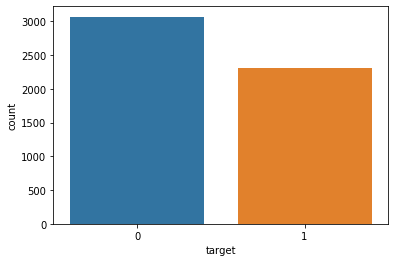

In [10]:
import seaborn as sns
ax = sns.countplot(train_df['target'])

## wordclouds

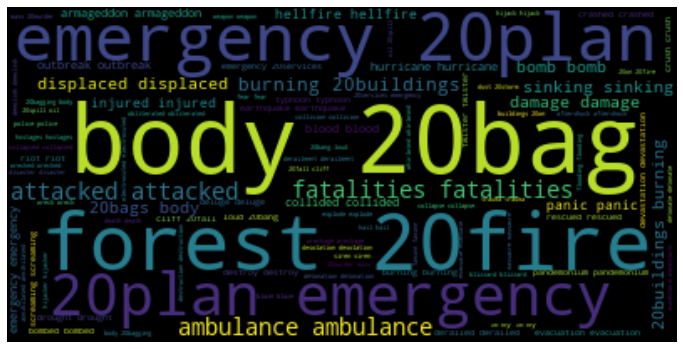

In [11]:
def renderWordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    F = plt.gcf()
    Size = F.get_size_inches()
    F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
    plt.show()
renderWordcloud(text)

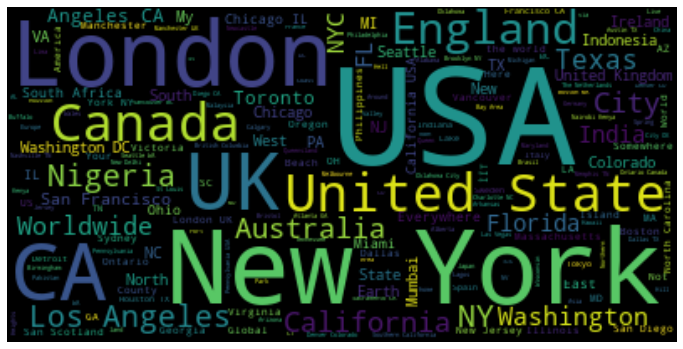

In [12]:
text = " ".join(keyword for keyword in train_has_location_df.location)
renderWordcloud(text)

## Unique words

In [13]:
len(train_has_keyword_df.keyword.unique())

221

In [14]:
len(train_has_location_df.location.unique())

2488

## Relationship between categorical vars & target

### relationship between keyword and target

In [15]:
group_keyword_sum_target = train_has_keyword_df.groupby("keyword").sum().sort_values("target")
group_keyword_len = train_has_keyword_df.groupby("keyword").count()
group_keyword_sum_target#['true/all'] = group_keyword_sum_target.target / group_keyword_len.target

,index,id,target
keyword,,,
body%20bag,20289,29357,0
aftershock,3198,4619,0
electrocute,70860,101682,0
body%20bags,32149,46579,0
ruin,146381,209154,1
...,...,...,...
oil%20spill,136722,195476,25
derailment,66395,95242,27
wreckage,210682,301288,28


In [16]:
pd.set_option('display.max_rows', None)
group_keyword_sum_target

,index,id,target
keyword,,,
body%20bag,20289,29357,0
aftershock,3198,4619,0
electrocute,70860,101682,0
body%20bags,32149,46579,0
ruin,146381,209154,1
epicentre,36067,51751,1
avalanche,9032,13103,1
bloody,20680,29919,1
blew%20up,16791,24270,1


### correlation between keyword and Target

#### contigency table

In [17]:
df_target_1 = train_has_keyword_df['target']==1
df_target_1.head()

26     True
27    False
28     True
29    False
30    False
Name: target, dtype: bool

In [18]:
pd.crosstab(train_has_keyword_df['keyword'], [df_target_1], rownames=['keyword'], colnames=['target'])

target,False,True
keyword,,
ablaze,14,9
accident,10,15
aftershock,27,0
airplane%20accident,4,20
ambulance,13,20
annihilated,18,9
annihilation,11,9
apocalypse,17,8
armageddon,26,4


### relationship between location and target: percentage of true targets per location

In [19]:
group_location_sum_target = train_has_location_df.groupby("location").sum().sort_values("target")
group_location_len = train_has_location_df.groupby("location").count()
group_location_sum_target['true/all'] = group_location_sum_target.target / group_location_len.target

In [20]:
group_location_sum_target.sort_values(by=['target'], ascending=False)[:50]

,index,id,target,true/all
location,,,,
USA,326273,466357,53,0.654321
United States,159046,227181,20,0.526316
Nigeria,98978,141372,17,0.772727
Mumbai,73905,105715,13,0.812500
"Washington, DC",58771,84182,12,0.750000
India,53006,75773,12,0.800000
UK,58929,84162,11,0.578947
London,119112,170478,10,0.333333
Canada,77445,110758,10,0.555556


In [21]:
pd.set_option('display.max_rows', 20)

### How are numbers formatted in tweets?

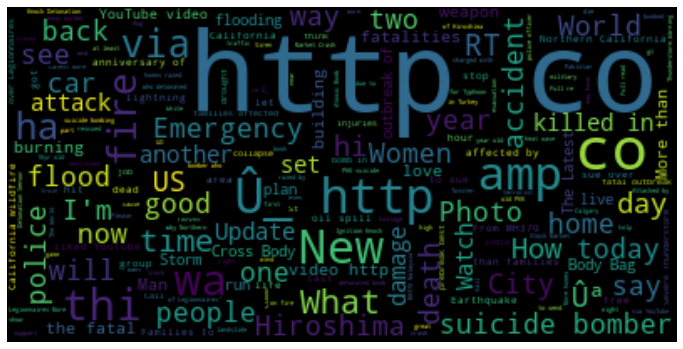

In [22]:
import re
pattern = re.compile("[0-9]")
numbers_df = train_df[train_df['text'].str.contains('[0-9]', regex= True, na=False)]
number_texts = [keyword if pattern.search(keyword) else None for keyword in numbers_df.text]
text = " ".join(number_texts)
renderWordcloud(text)






# Models

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [23]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [24]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [25]:
example_train_vectors[4]

<1x54 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

The above tells us that:
1. There are 54 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [26]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])
## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
dev_vectors = count_vectorizer.transform(dev_df["text"])

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [27]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [28]:
%%time
clf.fit(train_vectors, train_df["target"])
predictions = clf.predict(dev_vectors);
print(classification_report(dev_df['target'], predictions))



              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1272
           1       0.77      0.67      0.72       968

    accuracy                           0.77      2240
   macro avg       0.77      0.76      0.76      2240
weighted avg       0.77      0.77      0.77      2240

CPU times: user 246 ms, sys: 3.06 ms, total: 249 ms
Wall time: 68.7 ms


* The above scores aren't terrible! It looks like our assumption will score roughly 0.8 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!


# Feature engineering

### use keywords for prediction

In [29]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_replaced_na_keyword = train_df.copy()
train_replaced_na_keyword['keyword'] = train_df['keyword'].fillna(' ')
train_vectors = count_vectorizer.fit_transform(train_replaced_na_keyword["keyword"])

dev_replaced_na_keyword = dev_df.copy()
dev_replaced_na_keyword['keyword'] = dev_df['keyword'].fillna(' ')
dev_vectors = count_vectorizer.transform(dev_replaced_na_keyword["keyword"])


In [30]:
train_replaced_na_keyword

,index,id,keyword,location,text,target
0,0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,1,4,,NaN,Forest fire near La Ronge Sask. Canada,1
2,2,5,,NaN,All residents asked to 'shelter in place' are ...,1
3,3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1
4,4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...,...
5368,7606,10866,,NaN,Suicide bomber kills 15 in Saudi security site...,1
5369,7607,10867,,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
5370,7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1
5371,7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [31]:
train_vectors[1].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors, train_df["target"])
predictions = clf.predict(dev_vectors);
print(classification_report(dev_df['target'], predictions))



              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1272
           1       0.71      0.61      0.66       968

    accuracy                           0.73      2240
   macro avg       0.72      0.71      0.72      2240
weighted avg       0.73      0.73      0.72      2240



### use tweet text in combination with keyword

In [33]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_textandkeyword_df = train_df.copy()
train_textandkeyword_df['keyword'] = train_df['keyword'].fillna(' ')
train_textandkeyword_df['textandkeyword'] = train_textandkeyword_df['text'] + " // " + train_textandkeyword_df['keyword']
train_vectors = count_vectorizer.fit_transform(train_textandkeyword_df["textandkeyword"])



dev_textandkeyword_df = dev_df.copy()
dev_textandkeyword_df['keyword'] = dev_df['keyword'].fillna(' ')
dev_textandkeyword_df['textandkeyword'] = dev_textandkeyword_df['text'] + " // " + dev_textandkeyword_df['keyword']
dev_vectors = count_vectorizer.transform(dev_textandkeyword_df["textandkeyword"])



In [34]:
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors, train_df["target"])
predictions = clf.predict(dev_vectors);
print(classification_report(dev_df['target'], predictions))




              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1272
           1       0.78      0.69      0.73       968

    accuracy                           0.78      2240
   macro avg       0.78      0.77      0.77      2240
weighted avg       0.78      0.78      0.78      2240



Adding keyword to text reduces the score

### use only text but only over tweets that have keywords

In [35]:
clf = linear_model.RidgeClassifier()
train_vectors = count_vectorizer.fit_transform(train_textandkeyword_df["text"])
dev_vectors = count_vectorizer.transform(dev_textandkeyword_df["text"])
clf.fit(train_vectors, train_df["target"])
predictions = clf.predict(dev_vectors);
print(classification_report(dev_df['target'], predictions))




              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1272
           1       0.77      0.67      0.72       968

    accuracy                           0.77      2240
   macro avg       0.77      0.76      0.76      2240
weighted avg       0.77      0.77      0.77      2240



#  Vector representations

### Use TF-IDF to highlight important words in the text

Select top 10 words from every tweet using TF-IDF and feed them to a classifier

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
clf = linear_model.RidgeClassifier()
train_vectors = vectorizer.fit_transform(train_df["text"])
dev_vectors = vectorizer.transform(dev_df["text"])
clf.fit(train_vectors, train_df["target"])
predictions = clf.predict(dev_vectors);
print(classification_report(dev_df['target'], predictions))





              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1272
           1       0.79      0.71      0.75       968

    accuracy                           0.80      2240
   macro avg       0.80      0.79      0.79      2240
weighted avg       0.80      0.80      0.79      2240



not removing stop words is better:

In [37]:

vectorizer = TfidfVectorizer()
clf = linear_model.RidgeClassifier()
train_vectors = vectorizer.fit_transform(train_df["text"])
dev_vectors = vectorizer.transform(dev_df["text"])
clf.fit(train_vectors, train_df["target"])
predictions = clf.predict(dev_vectors);
print(classification_report(dev_df['target'], predictions))



              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1272
           1       0.78      0.71      0.75       968

    accuracy                           0.79      2240
   macro avg       0.79      0.78      0.78      2240
weighted avg       0.79      0.79      0.79      2240



### <a id="best_shallow">Best model so far: ridge classifier using TF-IDF for text encoding</a>

In [38]:
from sklearn.pipeline import Pipeline
clf = linear_model.RidgeClassifier()
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))




              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1272
           1       0.78      0.71      0.75       968

    accuracy                           0.79      2240
   macro avg       0.79      0.78      0.78      2240
weighted avg       0.79      0.79      0.79      2240



# <a id="shallow_learning">Evaluate multiple classifier models</a>

In [39]:
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = linear_model.RidgeClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [40]:
%%time




clf = linear_model.RidgeClassifier()
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), ('clf', ClfSwitcher())])



parameters = [
    {
        'clf__estimator': [SVC()],
    },
    {
        'clf__estimator': [SGDClassifier()],
    },
    {
        'clf__estimator': [MultinomialNB()],
    },
    {
        'clf__estimator': [linear_model.RidgeClassifier()],
    },
    {
        'clf__estimator': [MLPClassifier(random_state=1, max_iter=200, early_stopping=True)],
    },
    {
        'clf__estimator': [RandomForestClassifier()]
    }
]


gscv = GridSearchCV(pipeline, parameters, cv=3, n_jobs=12, return_train_score=True, verbose=3, scoring='f1')
gscv.fit(train_df["text"], train_df["target"])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  18 | elapsed:    2.6s remaining:   20.9s
[Parallel(n_jobs=12)]: Done   9 out of  18 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=12)]: Done  16 out of  18 | elapsed:   20.6s remaining:    2.6s
[Parallel(n_jobs=12)]: Done  18 out of  18 | elapsed:   21.9s finished


CPU times: user 45.3 s, sys: 1.65 s, total: 47 s
Wall time: 33.7 s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [41]:
df = pd.DataFrame(gscv.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.986048,0.023716,1.045234,0.028878,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'clf__estimator': SVC(C=1.0, break_ties=False...",0.607201,0.584832,0.659794,0.617276,0.031421,5,0.976877,0.976573,0.976077,0.976509,0.000330
1,0.326861,0.014903,0.077508,0.007096,"SGDClassifier(alpha=0.0001, average=False, cla...","{'clf__estimator': SGDClassifier(alpha=0.0001,...",0.625514,0.638271,0.701410,0.655065,0.033182,4,0.985525,0.986083,0.984127,0.985245,0.000823
2,0.297603,0.007574,0.085797,0.007872,"MultinomialNB(alpha=1.0, class_prior=None, fit...","{'clf__estimator': MultinomialNB(alpha=1.0, cl...",0.655963,0.642229,0.700549,0.666247,0.024895,2,0.911493,0.906526,0.908506,0.908841,0.002042
3,0.333515,0.001334,0.071833,0.001217,"RidgeClassifier(alpha=1.0, class_weight=None, ...","{'clf__estimator': RidgeClassifier(alpha=1.0, ...",0.625821,0.636240,0.713731,0.658597,0.039217,3,0.975671,0.978979,0.973083,0.975911,0.002413
4,18.209930,0.605186,0.043925,0.010613,"MLPClassifier(activation='relu', alpha=0.0001,...",{'clf__estimator': MLPClassifier(activation='r...,0.652303,0.642215,0.710410,0.668309,0.030053,1,0.935839,0.930055,0.943643,0.936512,0.005567
5,5.550131,0.318199,0.492468,0.022179,"RandomForestClassifier(bootstrap=True, ccp_alp...",{'clf__estimator': RandomForestClassifier(boot...,0.510848,0.490126,0.556098,0.519024,0.027546,6,0.995625,0.997029,0.995289,0.995981,0.000753


compare best two classifier: MultinomialNB & MLPClassifier

In [42]:
%%time
clf = MultinomialNB()
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))





              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1272
           1       0.88      0.63      0.74       968

    accuracy                           0.81      2240
   macro avg       0.83      0.78      0.79      2240
weighted avg       0.82      0.81      0.80      2240

CPU times: user 317 ms, sys: 9.1 ms, total: 326 ms
Wall time: 167 ms


In [43]:
%%time
clf = MLPClassifier(random_state=1, max_iter=200, early_stopping=True)
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))



              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1272
           1       0.81      0.70      0.75       968

    accuracy                           0.80      2240
   macro avg       0.80      0.79      0.79      2240
weighted avg       0.80      0.80      0.80      2240

CPU times: user 53.2 s, sys: 1.83 s, total: 55 s
Wall time: 14 s


hyperparameter search for MultinomialNB

In [44]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])



parameters = [
    {
        'clf__alpha': [1, 0, 0.5],
        'clf__fit_prior': [True, False]
    },
]


gscv = GridSearchCV(pipeline, parameters, cv=3, n_jobs=12, return_train_score=True, verbose=3, scoring='f1')
gscv.fit(train_df["text"], train_df["target"])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  18 | elapsed:    0.6s remaining:    4.8s
[Parallel(n_jobs=12)]: Done   9 out of  18 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=12)]: Done  16 out of  18 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  18 out of  18 | elapsed:    1.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [45]:
df = pd.DataFrame(gscv.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.287894,0.005169,0.102427,0.002317,1,True,"{'clf__alpha': 1, 'clf__fit_prior': True}",0.615385,0.615034,0.700590,0.643670,0.040249,4,0.869159,0.877996,0.876517,0.874557,0.003865
1,0.306482,0.003557,0.098270,0.001774,1,False,"{'clf__alpha': 1, 'clf__fit_prior': False}",0.660993,0.656876,0.719378,0.679082,0.028543,2,0.895009,0.901205,0.903997,0.900070,0.003756
2,0.308735,0.009736,0.089260,0.003631,0,True,"{'clf__alpha': 0, 'clf__fit_prior': True}",0.641661,0.610499,0.667076,0.639745,0.023137,6,0.989515,0.992481,0.989529,0.990508,0.001395
3,0.275789,0.010260,0.097249,0.003299,0,False,"{'clf__alpha': 0, 'clf__fit_prior': False}",0.641879,0.617408,0.669874,0.643053,0.021435,5,0.990838,0.992815,0.991208,0.991620,0.000858
4,0.173856,0.006610,0.059605,0.002508,0.5,True,"{'clf__alpha': 0.5, 'clf__fit_prior': True}",0.631822,0.640057,0.711911,0.661263,0.035971,3,0.906435,0.908458,0.914857,0.909917,0.003590
5,0.158649,0.006934,0.058234,0.001275,0.5,False,"{'clf__alpha': 0.5, 'clf__fit_prior': False}",0.675920,0.661479,0.715987,0.684462,0.023058,1,0.917999,0.924381,0.933066,0.925149,0.006175


In [46]:
clf = MultinomialNB(fit_prior=False)
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1272
           1       0.83      0.69      0.76       968

    accuracy                           0.81      2240
   macro avg       0.81      0.79      0.80      2240
weighted avg       0.81      0.81      0.80      2240



# More advanced Vector representation techniques

## <a id="fast_text">Fast-text</a>

In [47]:
%%time
!pip install gensim

from typing import Callable, List, Optional, Tuple

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import gensim
import gensim.downloader as api
from nltk import ngrams
from gensim.models.keyedvectors import FastTextKeyedVectors
import random
fastText_model = api.load("fasttext-wiki-news-subwords-300")  

def randvec(w, n=50, lower=-1.0, upper=1.0):
    """Returns a random vector of length `n`. `w` is ignored."""
    return np.array([random.uniform(lower, upper) for i in range(n)])

def get_oov_fasttext(w):
    twograms = ngrams(w, 2)
    vectors = []
    for gram in twograms:
        word_2gram = gram[0] + gram[1]
        if word_2gram in fastText_model:
            vectors.append(fastText_model[word_2gram])
    if(len(vectors) > 0):
        return np.sum(vectors, axis=0)
    else:
        return randvec(w, n=300)
def fasttext_vec(w):    
    """Return `w`'s fastext representation if available, else return 
    a random vector."""
    if(w in fastText_model):
        return fastText_model[w]
    else:
        return get_oov_fasttext(w)
    
class FastTextTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, combine_strategy="concatenate", max_sentence_length=30):
        assert (combine_strategy=="concatenate" or combine_strategy=='mean')
        self.combine_strategy = combine_strategy
        self.max_sentence_length = max_sentence_length
        self.empty_word_token = "EOF"
        
    def transform(self, text_list):
        texts = text_list.tolist()
        result = [];
        for text in texts:
            vectors = [];
            words = text.split()
            if(self.combine_strategy == 'concatenate'):
                max_index = self.max_sentence_length
            else:
                max_index = len(words) 
            for index in range(max_index):
                if(len(words) > index):
                    word = words[index]
                else:
                    word = self.empty_word_token
                vectors.append(fasttext_vec(word))
            if(self.combine_strategy == 'concatenate'):
                result.append(np.concatenate(vectors))
            elif(self.combine_strategy == 'mean'):
                result.append(np.mean(vectors, axis=0))
        return result;

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

ERROR: Could not find a version that satisfies the requirement docutils<0.16,>=0.10 (from botocore<1.16.0,>=1.15.46->boto3->smart-open>=1.8.1->gensim) (from versions: none)
ERROR: No matching distribution found for docutils<0.16,>=0.10 (from botocore<1.16.0,>=1.15.46->boto3->smart-open>=1.8.1->gensim)
CPU times: user 4min 34s, sys: 2.59 s, total: 4min 37s
Wall time: 4min 47s


In [48]:
clf = SGDClassifier()
pipe = Pipeline([('vectorizer', FastTextTransformer(combine_strategy='concatenate')), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))




              precision    recall  f1-score   support

           0       0.70      0.65      0.67      1272
           1       0.58      0.64      0.61       968

    accuracy                           0.64      2240
   macro avg       0.64      0.64      0.64      2240
weighted avg       0.65      0.64      0.65      2240



In [49]:
clf = SGDClassifier()
pipe = Pipeline([('vectorizer', FastTextTransformer(combine_strategy='mean')), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1272
           1       0.75      0.60      0.67       968

    accuracy                           0.74      2240
   macro avg       0.74      0.72      0.73      2240
weighted avg       0.74      0.74      0.74      2240



Compare same model using TF-IDF rather than fast-text for encoding

In [50]:
clf = SGDClassifier()
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1272
           1       0.76      0.71      0.74       968

    accuracy                           0.78      2240
   macro avg       0.78      0.77      0.78      2240
weighted avg       0.78      0.78      0.78      2240



Encoding text with TF-IDF vectorizer proves better than fast-text, which makes sense because TF-IDF helps our model pay attention to important words, while fast-text doesn't. This means that a model that has attention mechanism may deliver promising results, later in this notebook I'll experiment with one.

# <a id="text_preprop">pre-processing techniques</a>

In [51]:
# normalise has several nltk data dependencies. Install these by running the following python commands:

import nltk
for dependency in ("brown", "names", "wordnet", "averaged_perceptron_tagger", "universal_tagset"):
    nltk.download(dependency)

[nltk_data] Error loading brown: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading names: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>
[nltk_data] Error loading universal_tagset: <urlopen error [Errno 8]
[nltk_data]     nodename nor servname provided, or not known>


In [6]:
!pip install sklearn
!pip install nltk
!pip install unidecode
!pip install normalise
!pip install contractions
import os
import string
import re
os.system('python3 -m spacy download en')# it doesnt work when running directly on terminal
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
import spacy
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
import nltk
import unidecode
from normalise import normalise
import contractions
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = stopwords.words("english")



def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    return contractions.fix(text);

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

#FIXME: for lemmatizing, normalizing and removing stop words we tokenize the text and then join all the tokens using Python String.join, when doing this info like some punctuation marks are dropped which reduces model's accuracy
#If you find a way to over come this problem please let me know in the comments!
def text_normalizer(comment, lemmatize, lowercase, remove_stopwords, remove_accents, normalize_contractions, normalize_URL, normalize_emoji, normalize_html, normalize_punctuation):
    if lowercase:
        comment = comment.lower()
    if(remove_accents):
        comment = remove_accented_chars(comment)
    if(normalize_contractions):
        comment = expand_contractions(comment)
    if(normalize_URL):
        comment = remove_URL(comment)
    if(normalize_emoji):
        comment = remove_emoji(comment)   
    if(normalize_html):
        comment = remove_html(comment)   
    if(normalize_punctuation):
        comment = remove_punctuation(comment)   
    if(remove_stopwords):
        comment = nlp(comment)
        words = [];
        for token in comment:
            if not remove_stopwords or (remove_stopwords and token.text not in stops):
                    words.append(token.text)
        comment = " ".join(words)
    if(lemmatize):
        comment = nlp(comment)
        comment = " ".join(word.lemma_.strip() for word in comment)
    return comment


class PrePropTextTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, lemmatize=False, lowercase=False, remove_stopwords=False, remove_accents=False, normalize_contractions=False, normalize_URL=False, normalize_emoji=False, normalize_html=False, normalize_punctuation=False):
        self.lemmatize=lemmatize
        self.lowercase=lowercase
        self.remove_stopwords=remove_stopwords
        self.remove_accents=remove_accents
        self.normalize_contractions=normalize_contractions
        self.normalize_URL=normalize_URL
        self.normalize_emoji=normalize_emoji
        self.normalize_html=normalize_html
        self.normalize_punctuation=normalize_punctuation
        
    def transform(self, text_list):
        texts = text_list.tolist()
        result = [];
        for text in texts:
            result.append(text_normalizer(text, self.lemmatize, self.lowercase, self.remove_stopwords, self.remove_accents, self.normalize_contractions, self.normalize_URL, self.normalize_emoji, self.normalize_html, self.normalize_punctuation))
        return pd.Series(result)

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self



/Users/pablo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/pablo/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


#### baseline:

In [53]:
%%time
clf = MultinomialNB(fit_prior=False)
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1272
           1       0.83      0.69      0.76       968

    accuracy                           0.81      2240
   macro avg       0.81      0.79      0.80      2240
weighted avg       0.81      0.81      0.80      2240

CPU times: user 177 ms, sys: 5.97 ms, total: 183 ms
Wall time: 183 ms


### use preprocess_text to try improve baseline

In [54]:
%%time
clf = MultinomialNB()
pipe = Pipeline([('preprop', PrePropTextTransformer()), ('vectorizer', TfidfVectorizer()), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))



              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1272
           1       0.88      0.63      0.74       968

    accuracy                           0.81      2240
   macro avg       0.83      0.78      0.79      2240
weighted avg       0.82      0.81      0.80      2240

CPU times: user 149 ms, sys: 2.69 ms, total: 152 ms
Wall time: 151 ms


In [55]:
%%time
clf = MultinomialNB(fit_prior=False)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=True,
                                                    lowercase=True,
                                                    remove_stopwords=True,
                                                    remove_accents=True, 
                                                    normalize_contractions=True,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=True
                                                   )), ('vectorizer', TfidfVectorizer()), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1272
           1       0.79      0.73      0.75       968

    accuracy                           0.80      2240
   macro avg       0.79      0.79      0.79      2240
weighted avg       0.80      0.80      0.79      2240

CPU times: user 2.45 s, sys: 11.9 ms, total: 2.46 s
Wall time: 2.47 s


In [56]:
%%time
pipeline = Pipeline([('preprop', PrePropTextTransformer()),
                     ('vectorizer', TfidfVectorizer()),
                     ('predictor', MultinomialNB(fit_prior=False))])



parameters = [
        {'preprop__lemmatize': [True, False]},
        {'preprop__lowercase': [True, False]},
        {'preprop__remove_stopwords': [True, False]},
        {'preprop__remove_accents': [True, False]},
        {'preprop__normalize_contractions': [True, False]},
        {'preprop__normalize_URL': [True, False]},
        {'preprop__normalize_emoji': [True, False]},
        {'preprop__normalize_html': [True, False]},
        {'preprop__normalize_punctuation': [True, False]}
    ]

try:
    grid_search_pd = pd.read_csv("./text_preprop_gs_results.csv")
except:
    # FIXME: n_jobs has to be 1 or it crashes
    gscv = GridSearchCV(pipeline, parameters, cv=3, n_jobs=1, return_train_score=True, verbose=3, scoring='f1')
    gscv.fit(train_df["text"], train_df["target"])
    grid_search_pd = pd.DataFrame(gscv.cv_results_);
    grid_search_pd.to_csv("./text_preprop_gs_results.csv")
grid_search_pd


CPU times: user 3.96 ms, sys: 777 µs, total: 4.74 ms
Wall time: 4.38 ms


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprop__lemmatize,param_preprop__lowercase,param_preprop__remove_stopwords,param_preprop__remove_accents,param_preprop__normalize_contractions,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,1.521020,0.078779,0.733781,0.070288,True,NaN,NaN,NaN,NaN,...,0.642322,0.709049,0.667575,0.029558,18,0.874571,0.883572,0.883959,0.880701,0.004337
1,1,0.107130,0.004077,0.041534,0.002215,False,NaN,NaN,NaN,NaN,...,0.645617,0.729412,0.679664,0.035965,3,0.883244,0.889269,0.888080,0.886864,0.002606
2,2,0.109926,0.003275,0.044028,0.000201,NaN,True,NaN,NaN,NaN,...,0.645617,0.729412,0.679664,0.035965,3,0.883244,0.889269,0.888080,0.886864,0.002606
3,3,0.111415,0.005880,0.042565,0.002891,NaN,False,NaN,NaN,NaN,...,0.645617,0.729412,0.679664,0.035965,3,0.883244,0.889269,0.888080,0.886864,0.002606
4,4,1.465718,0.103980,0.720927,0.029279,NaN,NaN,True,NaN,NaN,...,0.632681,0.718346,0.671605,0.035407,17,0.903874,0.907744,0.909348,0.906988,0.002298
5,5,0.106817,0.006529,0.041421,0.000653,NaN,NaN,False,NaN,NaN,...,0.645617,0.729412,0.679664,0.035965,3,0.883244,0.889269,0.888080,0.886864,0.002606
6,6,0.134202,0.005368,0.055808,0.001810,NaN,NaN,NaN,True,NaN,...,0.645980,0.730245,0.679723,0.036390,2,0.884221,0.890032,0.888134,0.887462,0.002419
7,7,0.136559,0.017425,0.052978,0.007518,NaN,NaN,NaN,False,NaN,...,0.645617,0.729412,0.679664,0.035965,3,0.883244,0.889269,0.888080,0.886864,0.002606
8,8,0.143289,0.015360,0.065939,0.016383,NaN,NaN,NaN,NaN,True,...,0.647087,0.731574,0.679506,0.037185,15,0.882583,0.887144,0.886131,0.885286,0.001956
9,9,0.099624,0.004046,0.038768,0.001409,NaN,NaN,NaN,NaN,False,...,0.645617,0.729412,0.679664,0.035965,3,0.883244,0.889269,0.888080,0.886864,0.002606


## best result so far using text preprocessing:

In [57]:
%%time
clf = MultinomialNB(fit_prior=False)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', TfidfVectorizer()), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1272
           1       0.82      0.71      0.76       968

    accuracy                           0.81      2240
   macro avg       0.81      0.80      0.80      2240
weighted avg       0.81      0.81      0.80      2240

CPU times: user 213 ms, sys: 3.64 ms, total: 217 ms
Wall time: 217 ms


### Does using a tweet tokenizer improve it?

In [58]:
%%time
from nltk.tokenize import TweetTokenizer
clf = MultinomialNB(fit_prior=False)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', TfidfVectorizer(tokenizer=TweetTokenizer().tokenize)), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1272
           1       0.82      0.68      0.75       968

    accuracy                           0.80      2240
   macro avg       0.80      0.79      0.79      2240
weighted avg       0.80      0.80      0.80      2240

CPU times: user 451 ms, sys: 3.39 ms, total: 454 ms
Wall time: 454 ms


# More advanced word embeddings

### BERT

In [59]:
from typing import Callable, List, Optional, Tuple

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch
!pip install transformers
from transformers import BertModel, BertTokenizer


def mean_across_all_tokens(hidden_states):
    return torch.mean(hidden_states[-1], dim=1)

def sum_all_tokens(hidden_states):
    return torch.sum(hidden_states[-1], dim=1)

def concat_all_tokens(hidden_states):
    batch_size, max_tokens, emb_dim = hidden_states[-1].shape
    return torch.reshape(hidden_states[-1], (batch_size, max_tokens * emb_dim))

def CLS_token_embedding(hidden_states):
    return hidden_states[-1][:, 0, :]

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            max_length: int = 60,
            tokenizer = BertTokenizer.from_pretrained("bert-base-uncased"),
            model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True),
            embedding_func = mean_across_all_tokens,
            combine_sentence_tokens=True
    ):
        self.tokenizer = tokenizer;
        self.combine_sentence_tokens = combine_sentence_tokens;
        self.embedding_func = embedding_func;
        self.model = model
        self.model.eval()
        self.max_length = max_length

    def _tokenize(self, text_list: List[str]) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        input_ids = self.tokenizer.batch_encode_plus(text_list,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length,
                                                    pad_to_max_length=True
                                                    )["input_ids"]

        return torch.LongTensor(input_ids)
         

    def _tokenize_and_predict(self, text_list: List[str]) -> torch.tensor:
        input_ids_tensor = self._tokenize(text_list)
        out = self.model(input_ids=input_ids_tensor)
        hidden_states = out[2]
        if(self.combine_sentence_tokens):
            return self.embedding_func(hidden_states)
        else:
            return hidden_states[-1];
    
    def transform(self, text_list: List[str]):
        if isinstance(text_list, pd.Series):
            text_list = text_list.tolist()

        with torch.no_grad():
            return self._tokenize_and_predict(text_list)

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [60]:
bertTransformer = BertTransformer(combine_sentence_tokens=False)
bertTransformer.transform(["pablo", "I love Pablo"]).shape

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


torch.Size([2, 60, 768])

In [61]:
%%time
clf = linear_model.RidgeClassifier()
pipe = Pipeline([('vectorizer', BertTransformer()), ('predictor', clf)])
pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1272
           1       0.84      0.71      0.77       968

    accuracy                           0.82      2240
   macro avg       0.82      0.80      0.81      2240
weighted avg       0.82      0.82      0.81      2240

CPU times: user 22min 44s, sys: 3min 51s, total: 26min 35s
Wall time: 10min 40s


text preprocessing, BERT encoding, RidgeClassifier classifier

In [62]:
%%time
clf = linear_model.RidgeClassifier()
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer()), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


KeyboardInterrupt: 

<a id='bert-NN'></a>
BERT embeddings feeded to feed forward NN

In [63]:
%%time
clf = MLPClassifier(random_state=1, max_iter=200, early_stopping=True)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer()), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


KeyboardInterrupt: 

## hyper param search MLP classifier

reduce num of ephocs and set cv=2 to reduce training time

In [64]:
%%time
clf = MLPClassifier(random_state=1, max_iter=100, early_stopping=True)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer()), ('clf', clf)])

parameters = [
        {'clf__hidden_layer_sizes': [(100, 100), (100,), (100, 50), (50, 50)]}
    ]

try:
    grid_search_pd = pd.read_csv("./mlp_clf_gs_results.csv")
except:
    # FIXME: n_jobs has to be 1 or it crashes
    gscv = GridSearchCV(pipe, parameters, cv=2, n_jobs=1, return_train_score=True, verbose=3, scoring='f1')
    gscv.fit(train_df["text"], train_df["target"])
    grid_search_pd = pd.DataFrame(gscv.cv_results_);
    grid_search_pd.to_csv("./mlp_clf_gs_results.csv")
grid_search_pd


CPU times: user 11 ms, sys: 52.6 ms, total: 63.5 ms
Wall time: 160 ms


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__hidden_layer_sizes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0,176.203025,0.066645,180.123401,1.827412,"(100, 100)","{'clf__hidden_layer_sizes': (100, 100)}",0.694598,0.759624,0.727111,0.032513,4,0.771110,0.811838,0.791474,0.020364
1,1,159.217862,2.034790,161.468970,4.279430,"(100,)","{'clf__hidden_layer_sizes': (100,)}",0.744589,0.741753,0.743171,0.001418,1,0.833887,0.803493,0.818690,0.015197
2,2,171.306889,3.241988,167.427857,6.134536,"(100, 50)","{'clf__hidden_layer_sizes': (100, 50)}",0.716093,0.741492,0.728792,0.012700,3,0.786059,0.795749,0.790904,0.004845
3,3,172.984756,15.519421,160.831675,0.003957,"(50, 50)","{'clf__hidden_layer_sizes': (50, 50)}",0.755847,0.720445,0.738146,0.017701,2,0.827823,0.797503,0.812663,0.015160


In [65]:
%%time
clf = MLPClassifier(random_state=1, max_iter=100, early_stopping=True)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer()), ('clf', clf)])

parameters = [
        {'clf__hidden_layer_sizes': [(100, 50, 50), (100,100, 50)]}
    ]

try:
    grid_search_pd = pd.read_csv("./mlp_clf2_gs_results.csv")
except:
    # FIXME: n_jobs has to be 1 or it crashes
    gscv = GridSearchCV(pipe, parameters, cv=2, n_jobs=1, return_train_score=True, verbose=3, scoring='f1')
    gscv.fit(train_df["text"], train_df["target"])
    grid_search_pd = pd.DataFrame(gscv.cv_results_);
    grid_search_pd.to_csv("./mlp_clf2_gs_results.csv")
grid_search_pd


CPU times: user 5.05 ms, sys: 3.29 ms, total: 8.33 ms
Wall time: 14.1 ms


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__hidden_layer_sizes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0,166.065783,7.078328,345.301316,186.997585,"(100, 50, 50)","{'clf__hidden_layer_sizes': (100, 50, 50)}",0.745436,0.734118,0.739777,0.005659,2,0.828017,0.785135,0.806576,0.021441
1,1,180.600327,22.265216,170.922901,13.541509,"(100, 100, 50)","{'clf__hidden_layer_sizes': (100, 100, 50)}",0.755240,0.736736,0.745988,0.009252,1,0.800641,0.790339,0.795490,0.005151


Increasing FFN network layers doesn't make a significant improvement

### BERT compare different ways of generating sentence embeddings for classification: concatenate VS avg VS [CLS] token embedding

In [66]:
bertTransformer = BertTransformer()
bertTransformer.transform(["granola bars"]).shape

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


torch.Size([1, 768])

In [67]:
%%time
clf = MLPClassifier(random_state=1, max_iter=100, early_stopping=True)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer()), ('predictor', clf)])


parameters = [
        {'vectorizer__embedding_func': [sum_all_tokens, mean_across_all_tokens, concat_all_tokens, CLS_token_embedding]}
    ]

try:
    grid_search_pd = pd.read_csv("./emb_funcs_gs_results.csv")
except:
    # FIXME: n_jobs has to be 1 or it crashes
    gscv = GridSearchCV(pipe, parameters, cv=2, n_jobs=1, return_train_score=True, verbose=3, scoring='f1')
    gscv.fit(train_df["text"], train_df["target"])
    grid_search_pd = pd.DataFrame(gscv.cv_results_);
    grid_search_pd.to_csv("./emb_funcs_gs_results.csv")
grid_search_pd



CPU times: user 15.8 ms, sys: 880 µs, total: 16.7 ms
Wall time: 4.09 ms


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer__embedding_func,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0,306.982301,6.922266,289.749028,1.864129,<function sum_all_tokens at 0x1a5a1018c0>,{'vectorizer__embedding_func': <function sum_a...,0.692419,0.731926,0.712172,0.019754,4,0.771520,0.830262,0.800891,0.029371
1,1,290.643546,3.533829,293.952148,1.118215,<function mean_across_all_tokens at 0x1a5a101e60>,{'vectorizer__embedding_func': <function mean_...,0.758689,0.758202,0.758445,0.000244,1,0.786207,0.789781,0.787994,0.001787
2,2,349.478783,7.457804,287.970233,1.785064,<function concat_all_tokens at 0x1aa6e60440>,{'vectorizer__embedding_func': <function conca...,0.697527,0.758291,0.727909,0.030382,3,0.822624,0.840314,0.831469,0.008845
3,3,289.775770,6.618252,289.003973,1.489918,<function CLS_token_embedding at 0x1aa6e604d0>,{'vectorizer__embedding_func': <function CLS_t...,0.735818,0.735892,0.735855,0.000037,2,0.754045,0.810670,0.782358,0.028312


## XGBoost model

In [68]:
%%time 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from transformers import RobertaTokenizer, RobertaModel
from xgboost import XGBClassifier
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
clf = XGBClassifier(n_estimators=300)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer(model=model, tokenizer=tokenizer)), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


KeyboardInterrupt: 

# Sequential models

So far we've combined the word embeddings in some way and trained feed-fordward, shadow models, let's see what happens when our word embeddings are evaluated using a sequential model!

### <a id="lstms">LSTM classifiers</a>

#### Vanilla LSTM

In [69]:
%%time
bertTransformer = BertTransformer(combine_sentence_tokens=False)
X_train = bertTransformer.transform(train_df["text"])
X_dev = bertTransformer.transform(dev_df["text"])
y_train = train_df["target"].tolist()
y_dev = dev_df["target"].tolist()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


KeyboardInterrupt: 

In [70]:
%%time
from torch_rnn_classifier import TorchRNNClassifier
torch_rnn = TorchRNNClassifier(
        vocab=[],
        use_embedding=False,
        bidirectional=False,
        hidden_dim=50,
        max_iter=50,
        eta=0.05) 
_ = torch_rnn.fit(X_train, y_train)


KeyboardInterrupt



In [71]:
%%time
from sklearn.metrics import classification_report
predictions = torch_rnn.predict(X_dev)
print(classification_report(y_dev, predictions))

NameError: name 'X_dev' is not defined

####  BI-LSTM classifier

In [72]:
%%time
from torch_rnn_classifier import TorchRNNClassifier

torch_bi_lstm = TorchRNNClassifier(
        vocab=[],
        use_embedding=False,
        bidirectional=True,
        hidden_dim=50,
        max_iter=50,
        eta=0.05) 
_ = torch_bi_lstm.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [73]:
%%time
predictions = torch_bi_lstm.predict(X_dev)
print(classification_report(y_dev, predictions))


NameError: name 'X_dev' is not defined

#### BI-LSTM with attention

#### Manning 2015 Global Attention 

In [74]:
%%time
from torch_rnn_classifier_attn import TorchRNNClassifier
torch_bilstm_attn_manning2015 = TorchRNNClassifier(
        vocab=[],
        use_embedding=False,
        attention="GlobalAttnManning2015",
        bidirectional=True,
        hidden_dim=50,
        max_iter=30,
        eta=0.05) 
_ = torch_bilstm_attn_manning2015.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [75]:
%%time
predictions = torch_bilstm_attn_manning2015.predict(X_dev)
print(classification_report(y_dev, predictions))


NameError: name 'X_dev' is not defined

#### <a id="shou_peng_attn">Shou, Peng, et al. 2016 Attention</a>

In [76]:
%%time
torch_bilstm_attn_ShouPeng2016 = TorchRNNClassifier(
        vocab=[],
        use_embedding=False,
        attention="AttnShouPeng2016",
        bidirectional=True,
        hidden_dim=50,
        max_iter=30,
        eta=0.05) 
_ = torch_bilstm_attn_ShouPeng2016.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [77]:
%%time
predictions = torch_bilstm_attn_ShouPeng2016.predict(X_dev)
print(classification_report(y_dev, predictions))


NameError: name 'X_dev' is not defined

# <a id="bert_e2e">BERT (finetuned)</a>

### Finetune BERT models for classification task

BERT model with an added single linear layer on top for classification. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

Even though we already tested a similar architecture in this notebook: [BERT embeddings feeded TO A SK-learn feed forward NN](#bert-NN), the below model has an advantage that makes it more promising: both the transformer used to generating the word embeddings and the classification layer weights are adjusted(https://arxiv.org/abs/2004.14448) 

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import logging
from simpletransformers.classification import ClassificationModel



class BertClassifierPredictor(BaseEstimator, ClassifierMixin):
    def __init__(self, model=ClassificationModel('roberta', 'roberta-base', args={"overwrite_output_dir": True},
                                                 use_cuda=False)):
        self.model = model
        logging.basicConfig(level=logging.INFO)
        transformers_logger = logging.getLogger("transformers")
        transformers_logger.setLevel(logging.WARNING)


    def fit(self, X, y):
        X = X.tolist()
        y = y.tolist()
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        d = {'text': X, 'labels': y}
        df = pd.DataFrame(data=d)
        self.model.train_model(df, output_dir="./simpletransformer_outputs")
        return self

    def predict(self, X):
        return self.model.predict(X.tolist())[0]


    
    

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [89]:
%%time
model = ClassificationModel('bert', './simpletransformer_outputs/checkpoint-bert-epoch-1', args={"overwrite_output_dir": True}, use_cuda=False)

clf = BertClassifierPredictor(model=model)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('predictor', clf)])

#pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1272
           1       0.80      0.67      0.73       968

    accuracy                           0.79      2240
   macro avg       0.79      0.77      0.78      2240
weighted avg       0.79      0.79      0.78      2240

CPU times: user 19min 17s, sys: 18.5 s, total: 19min 36s
Wall time: 5min 2s


### <a id="winner">Roberta(Finetuned)</a>

In [90]:
%%time
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
# Create a TransformerModel
model = ClassificationModel('roberta', './simpletransformer_outputs/checkpoint-roberta-epoch-1', args={"overwrite_output_dir": True}, use_cuda=False)

clf = BertClassifierPredictor(model=model)
pipe_roberta_finetuned = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('predictor', clf)])

pipe_roberta_finetuned.fit(train_df["text"], train_df["target"])
predictions = pipe_roberta_finetuned.predict(dev_df['text'])
print(classification_report(dev_df['target'], predictions))


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Running loss: 0.601304



INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to ./simpletransformer_outputs.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1272
           1       0.79      0.76      0.78       968

    accuracy                           0.81      2240
   macro avg       0.81      0.81      0.81      2240
weighted avg       0.81      0.81      0.81      2240

CPU times: user 3h 17min 54s, sys: 13min 55s, total: 3h 31min 50s
Wall time: 1h 2min 31s


## Roberta word vectors(not finetuned) + feed forward NN

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
clf = MLPClassifier(random_state=1, max_iter=200, early_stopping=True)
pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('vectorizer', BertTransformer(model=model, tokenizer=tokenizer)), ('predictor', clf)])

pipe.fit(train_df["text"], train_df["target"])
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))

## Roberta word vectors used in best model so far (biLSTM with attention)

In [ ]:
%%time
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
bertTransformer = BertTransformer(model=model, tokenizer=tokenizer, combine_sentence_tokens=False)
X_train = bertTransformer.transform(train_df["text"])
X_dev = bertTransformer.transform(dev_df["text"])
y_train = train_df["target"].tolist()
y_dev = dev_df["target"].tolist()


In [ ]:
%%time
from torch_rnn_classifier_attn import TorchRNNClassifier
torch_bilstm_attention_roberta_exp = TorchRNNClassifier(
        vocab=[],
        use_embedding=False,
        attention="AttnShouPeng2016",
        bidirectional=True,
        hidden_dim=50,
        max_iter=30,
        eta=0.05) 
_ = torch_bilstm_attention_roberta_exp.fit(X_train, y_train)

In [ ]:
%%time
predictions = torch_bilstm_attention_roberta_exp.predict(X_dev)
print(classification_report(y_dev, predictions))


## Spacy classifier(Architecture=Enseble)

From the doc(https://spacy.io/api/textcategorizer#architectures):  
Stacked ensemble of a bag-of-words model and a neural network model. The neural network uses a CNN with mean pooling and attention

In [ ]:
%%time
from spacy_text_classifier import SpacyClassifier
spacy_classifier = SpacyClassifier(n_iter=50)


pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('predictor', spacy_classifier)])

pipe.fit(train_df["text"], train_df["target"])

In [ ]:
%%time
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))

# <a id="gpt2">GPT-2</a>

Frozen(not finetuned during training) distill-GPT2 language model used to generate word embeddings + feed forward classification layer on top

In [ ]:
%%time
from GPT2_classifier import GPT2Classifier
checkpoint_path = "models/GPT2_CLS_CHECKPOINT_ephoc20.pth.tar"
gpt2_classifier = GPT2Classifier(max_iter=20, finetune_GPT2=False, batch_size=32, checkpoint_path=checkpoint_path,
                 base_dir=".", classes=[0,1])

pipe = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('predictor', gpt2_classifier)])

pipe.fit(train_df["text"], train_df["target"])




In [ ]:
%%time
predictions = pipe.predict(dev_df["text"]);
print(classification_report(dev_df['target'], predictions))

# <a id="Conclusions">Conclusions</a>

From comparing all the models tested on this notebook I observe that the best performing model for the task of tweet classification is: [Roberta classifier(Finetuned)](#winner)

Other interesting findings:
- using TF-IDF vectors + shallow learning(eg: ridge classifier) yields results that are hard to beat by most deep learning models [Link](#best_shallow)
- Adding attention to an LSTM classifier increases its accuracy noticeably, particularly when using shoug peng 2016 attention [Link](#shou_peng_attn)

# Follow up work

- Train word embeddings and LSTMs w attention together, so word vectors get fine tuned, this will definitely yield better results than when we don't finetune the word vectors and only train the LSTM classifier
- Can we place a NN on top of the LSTM and have it behave as an attention layer? if no why not?
- Oversample the minority class
- Use other types of attentions when working with RNNs Manning 2015 suggest a better type called local attention
- Explore bigger versions of GPT2
- Explore other ways of generating sentence embeddings(eg: add a CLS token and use its hidden state as sentence representation) using GPT2
- Finetune GPT2 model, my model only trains the classificaiton layer, tried to also finetune GPT2 and even the current code is supposed to be able to finetune it, but for some reason doesn't work

# Submit best model predictions to Kaggle

Train the final model on all available labelled data, the below df contains the examples used for training and dev sets during the notebooka

In [8]:
entire_train_df = pd.concat([train_df, dev_df])

In [14]:
%%time
# retrain best model on  all available data
model = ClassificationModel('roberta', './simpletransformer_outputs/checkpoint-roberta_submission-epoch-2', args={"overwrite_output_dir": True, "num_train_epochs": 2}, use_cuda=False)

clf = BertClassifierPredictor(model=model)
pipe_roberta_finetuned_submit = Pipeline([('preprop', PrePropTextTransformer(lemmatize=False,
                                                    lowercase=False,
                                                    remove_stopwords=False,
                                                    remove_accents=True, 
                                                    normalize_contractions=False,
                                                    normalize_URL=True,
                                                    normalize_emoji=True,
                                                    normalize_html=True,
                                                    normalize_punctuation=False
                                                   )), ('predictor', clf)])
#pipe_roberta_finetuned_submit.fit(entire_train_df["text"], entire_train_df["target"])


CPU times: user 2.76 s, sys: 611 ms, total: 3.37 s
Wall time: 3.47 s


In [15]:
test_vectors = test_df['text']
sample_submission = pd.read_csv("./data/sample_submission.csv")
sample_submission["target"] = pipe_roberta_finetuned_submit.predict(test_vectors)
sample_submission.head()

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
sample_submission.to_csv("./data/submission.csv", index=False)